In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch 
import torchvision as tv
from torch.utils.data import  DataLoader,datasets,Subset
from torchvision import transforms,datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torchvision.models as models
import torchtext
from torchtext.data import get_tokenizer
# from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
print(device)

cpu


In [3]:
embedding_dims = 2
batch_size = 32
epochs = 50

In [4]:
test_triplets = pd.read_csv('./task4_be9ai3nsdj/test_triplets.txt',delimiter="\t",header=None)
train_triplets = pd.read_csv('./task4_be9ai3nsdj/train_triplets.txt',delimiter="\t",header=None)
train_triplets.head()
train_triplets_split= train_triplets[0].str.split(" ", n = 3, expand = True) 

In [5]:
transform = transforms.Compose([transforms.Scale((224,224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder('./task4_be9ai3nsdj/food/',transform = transform)

A:\Anaconda\envs\torch\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False,num_workers=6)
images, labels = next(iter(dataloader))
plt.imshow(images[3].permute(1, 2, 0) )

In [ ]:
dataset = datasets.

In [113]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [1]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

NameError: name 'nn' is not defined

In [115]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [116]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [140]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img) in enumerate(tqdm(test, desc="Training", leave=False)):
        
        anchor_img = test[0].to(device)
        positive_img = test[1].to(device)
        negative_img = test[2].to(device)
        optimizer.zero_grad()
        anchor_out = model(anchor_img.unsqueeze(0).permute(1,0,2,3))
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "<ipython-input-114-89a8d2a02c07>", line 23, in forward
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
            ~~~~~~ <--- HERE
        x = self.fc(x)
        # x = nn.functional.normalize(x)
RuntimeError: shape '[-1, 1024]' is invalid for input of size 967872


In [15]:
images[0]

tensor([[[-0.1143, -0.1314, -0.0458,  ..., -0.0629,  0.0569, -0.0629],
         [-0.3027,  0.0569, -0.0287,  ...,  0.0227, -0.0458,  0.0741],
         [-0.0972,  0.0398,  0.1254,  ..., -0.0287,  0.0398,  0.0912],
         ...,
         [-0.5938, -0.6623, -0.9363,  ..., -0.3541, -0.8164, -1.0390],
         [-0.8678, -0.7137, -0.9020,  ...,  0.3652, -0.6281, -0.3883],
         [-0.7650, -0.7137, -0.9705,  ...,  0.5878, -0.4739, -0.0972]],

        [[-0.1975, -0.2150, -0.1099,  ..., -0.1975, -0.0574, -0.1625],
         [-0.3375,  0.0126, -0.0749,  ..., -0.0749, -0.1275,  0.0126],
         [-0.0574,  0.0651,  0.1527,  ..., -0.0399,  0.0476,  0.0826],
         ...,
         [-0.7927, -0.8803, -1.1429,  ..., -0.2500, -0.2850, -0.5826],
         [-1.0203, -0.9328, -1.1253,  ...,  0.4678, -0.0224,  0.1352],
         [-0.9153, -0.9328, -1.1954,  ...,  0.6954,  0.1352,  0.4328]],

        [[-0.5321, -0.4798, -0.2707,  ..., -0.3578, -0.2532, -0.3927],
         [-0.6541, -0.2358, -0.2184,  ..., -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


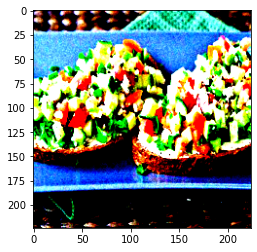

In [40]:
plt.imshow(images[31].permute(1, 2, 0) )

In [39]:
np.shape(images[31])

torch.Size([3, 224, 224])

In [31]:
train_triplets_split= train_triplets[0].str.split(" ", n = 3, expand = True) 

In [14]:
for i in train

,0,1,2
0,02461,03450,02678
1,02299,02499,04987
2,04663,01056,03029
3,04532,01186,01297
4,03454,03809,02204
...,...,...,...
59510,00466,02952,02530
59511,02646,03580,02359
59512,03255,04844,04334
59513,02136,04619,00161


In [9]:
transform = transforms.Compose([transforms.Scale((224,224)),
#                                 transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder('./task4_be9ai3nsdj/food/',transform = transform)

A:\Anaconda\envs\torch\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
def load_triplets(triplet,i):
    anchor_file = triplet[0][i]
    truthy_file = triplet[1][i]
    falsy_file = triplet[2][i]
    input_image_file = './task4_be9ai3nsdj/food/food/'
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    anchor = preprocess(Image.open(input_image_file+anchor_file+'.jpg'))
    plt.imshow(anchor.permute(1,2,0))
    plt.show()
    truthy = preprocess(Image.open(input_image_file+truthy_file+'.jpg'))
    plt.imshow(truthy.permute(1,2,0))
    plt.show()
    falsy = preprocess(Image.open(input_image_file+falsy_file+'.jpg'))
    plt.imshow(falsy.permute(1,2,0))
    plt.show()
            

    stack = [anchor,truthy,falsy]
    
    return [anchor,truthy,falsy]

In [6]:
test = load_triplets(train_triplets_split,0)

NameError: name 'Image' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


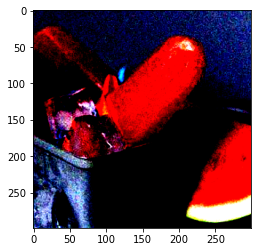

In [110]:
plt.imshow(test[0].permute(1,2,0))

In [68]:
from PIL import Image
from torchvision import transforms
input_image = Image.open('./task4_be9ai3nsdj/food/food/'+train_triplets_split[0][0]+'.jpg')
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
anchor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')

# with torch.no_grad():
#   output = model(input_batch)
# # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

In [69]:
anchor.shape

torch.Size([3, 299, 299])